# Прогнозирование количества заказов такси

## Описание проекта

Компания такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Требуется построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

## Функции

In [1]:
!pip install holidays catboost
!pip install -U pandas seaborn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: pandas in /home/jovyan/.local/lib/python3.7/site-packages (1.1.3)
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.0)


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import math
import timeit
import requests
import holidays
from urllib.parse import urlencode

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from collections import OrderedDict
from catboost import CatBoostRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit

In [4]:
LINKS = ["https://yadi.sk/d/Z8eyb3-vh-d5UQ"]
PATHS = ['/datasets/taxi.csv']

In [5]:
def rmse(y_true, y_pred):
  return mean_squared_error(y_true, y_pred)**0.5


In [6]:
def fit(model, X_train, y_train, X_test, y_test):
  model.fit(X_train, y_train)
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  print("RMSE train:         ", rmse(y_train, y_train_pred))
  print("RMSE test (max=48): ", rmse(y_test, y_test_pred))

  return model, y_test_pred

In [7]:
def plot(*data, size=(20,5), legend=['train', 'test']):
  _, ax = plt.subplots(figsize=size)
  for s in data:
    ax.plot(s)
  ax.legend(legend)
  plt.show()

In [8]:
def fit_model(model, X_train, y_train, X_test, y_test, size=(20,5), slice=(100,300)):
  model_fit, predictions = fit(model, X_train, y_train, X_test, y_test)
  plot(y_test.values[slice[0]:slice[1]], predictions[slice[0]:slice[1]], size=size)
  return model_fit


In [9]:
def find_holiday(day):
  ru_holidays = holidays.Russia()
  return int(day in ru_holidays)

In [10]:
def day_part(time_stamp):
  hour = time_stamp.hour

  if hour == 23 or ( 0 <= hour < 6):
    return 'night'
  elif 6 <= hour < 12:
    return 'morning'
  elif 12 <= hour < 18:
    return 'afternoon'
  elif 18 <= hour < 23:
    return 'evening'

In [11]:
def test_model(estimator, X_train, y_train, X_test, y_test):
  train_rmse = rmse(y_train, estimator.predict(X_train))
  test_rmse = rmse(y_test, estimator.predict(X_test))
  print('Train RMSE:', train_rmse)
  print('Test  RMSE:', test_rmse)
  return (train_rmse, test_rmse)

In [12]:
def make_features(data, target, max_lag=1, rolling_size=1, rolling_func=['mean']):
  data['month'] = data.index.month
  data['day'] = data.index.day
  data['dayofweek'] = data.index.dayofweek
  data['hour'] = data.index.hour
  data['weekend'] = data['dayofweek'].apply(lambda x: 1 if x in [6, 7] else 0)
  data['holiday'] = data.index.to_series().apply(find_holiday)
  data['day_part'] = data.index.to_series().apply(day_part)
  
  for lag in range(1, max_lag + 1):
      data['lag_{}'.format(lag)] = data[target].shift(lag)

  for func in rolling_func:
    name = 'rolling_' + func
    data[name] = data[target].shift().rolling(rolling_size).agg(func)


In [13]:
def load_data(paths, links=None, get_url=False):
    """
    Функция принимает пути до локальных файлов с данными и (опционально) ссылки
    для их скачивания.
    
    paths - локальные пути до файлов с данными
    links - ссылки для скачивания (Яндекс.Диск)
    """
    
    data_list = []
    url_list = []
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    
    if links != None and not links:
        raise Exception("Error: wrong 'links' value (nmust be not empty list)")
    
    if links:
        if len(paths) != len(links):
            raise Exception("Error: length of 'links' must be equal to length of 'paths'")

        if type(paths).__name__ != 'list' or type(links).__name__ != 'list':
            raise Exception("Error: variables 'links' and 'paths' must be 'list' type")

    for i in range(len(paths)):
        
        try:
            path = paths[i]
            data_list.append(pd.read_csv(path))
            
        except FileNotFoundError:
            # download from yandex disk
            public_key = links[i]
            print("Run load", public_key)
            
            # get download link
            final_url = base_url + urlencode(dict(public_key=public_key))
            response = requests.get(final_url)
            download_url = response.json()['href']

            if get_url:
              data_list.append(download_url)
            else:
              data = pd.read_csv(download_url)
              data_list.append(pd.DataFrame(data))
            print('Done.')
            
    return data_list

In [14]:
def test_split(df, target, test_size=0.3):
  train, test = train_test_split(df, shuffle=False, test_size=test_size)
  X_train = train.drop(target, axis=1)
  y_train = train[target]
  X_test = test.drop(target, axis=1)
  y_test = test[target]
  return (X_train, y_train, X_test, y_test)

## 1. Подготовка

In [15]:
taxi_url = load_data(PATHS, links=LINKS, get_url=True)[0]

In [16]:
taxi = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
taxi.head(10) 

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [17]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [18]:
print(taxi.index.is_monotonic)

True


In [19]:
taxi_hour = taxi.resample('1H').sum()
taxi_hour.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [20]:
taxi_hour.resample('1M').sum()

,num_orders
datetime,
2018-03-31,42768
2018-04-30,45939
2018-05-31,54820
2018-06-30,59906
2018-07-31,74405
2018-08-31,94973


В данных 26496 наблюдений за 6 месяцев с интервалом в 10 минут. Явных пропусков нет.

## Анализ

In [21]:
decomposed = seasonal_decompose(taxi_hour)


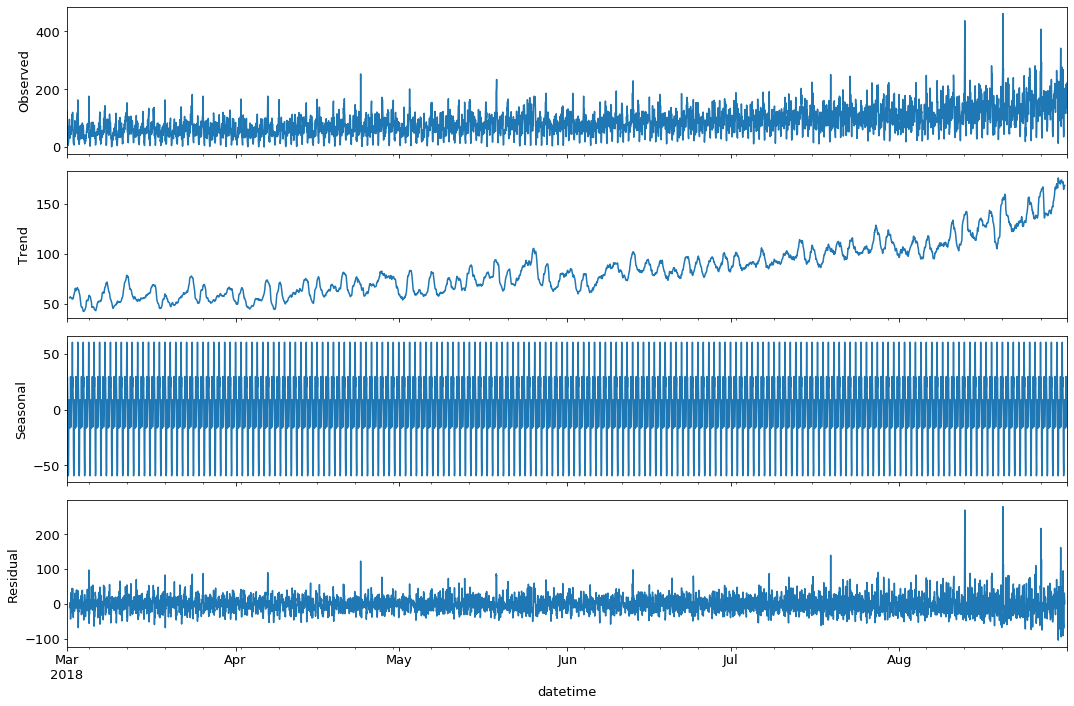

In [22]:
plt.rc('figure',figsize=(15,10))
plt.rc('font',size=13)
decomposed.plot();
plt.show()

In [23]:
taxi_hour["2018-03-01":"2018-03-31"].num_orders.describe()

count    744.000000
mean      57.483871
std       29.562439
min        1.000000
25%       39.000000
50%       55.000000
75%       75.000000
max      182.000000
Name: num_orders, dtype: float64

In [24]:
taxi_hour["2018-05-01":"2018-05-31"].num_orders.describe()


count    744.000000
mean      73.682796
std       34.849825
min        2.000000
25%       53.000000
50%       71.000000
75%       92.000000
max      234.000000
Name: num_orders, dtype: float64

In [25]:
taxi_hour["2018-07-01":"2018-07-31"].num_orders.describe()

count    744.00000
mean     100.00672
std       37.25477
min       11.00000
25%       76.00000
50%       98.00000
75%      122.00000
max      251.00000
Name: num_orders, dtype: float64

Из графиков и описания данных следует, что временной ряд близок к стационарному, не не является таковым:
* меняется среднее и медиана на протяжении наблюдаемого времени
* меняется стандартное отклонение.

Тренд говорит о том, что спрос на такси повышается в течение наблюдаемого полугодия.

Добавим признаки.

In [26]:
make_features(taxi_hour, 'num_orders', max_lag=6, rolling_size=24, rolling_func=['mean'])
taxi_hour.rename(columns={'rolling_mean':'roll_mean_24'}, inplace=True)

make_features(taxi_hour, 'num_orders', rolling_size=6, rolling_func=['mean'])
taxi_hour.rename(columns={'rolling_mean':'roll_mean_6'}, inplace=True)

taxi_hour.dropna(inplace=True)
taxi_hour.sample(5)

,num_orders,month,day,dayofweek,hour,weekend,holiday,day_part,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,roll_mean_24,roll_mean_6
datetime,,,,,,,,,,,,,,,,
2018-08-12 09:00:00,108,8,12,6,9,1,0,morning,97.0,24.0,22.0,51.0,111.0,136.0,104.791667,73.500000
2018-04-22 12:00:00,39,4,22,6,12,1,0,afternoon,50.0,48.0,56.0,61.0,9.0,9.0,58.958333,38.833333
2018-08-03 15:00:00,96,8,3,4,15,0,0,afternoon,75.0,106.0,96.0,105.0,159.0,114.0,106.416667,109.166667
2018-04-10 02:00:00,45,4,10,1,2,0,0,night,51.0,88.0,66.0,72.0,46.0,57.0,58.750000,63.333333
2018-07-25 15:00:00,119,7,25,2,15,0,0,afternoon,95.0,99.0,83.0,93.0,95.0,122.0,100.666667,97.833333


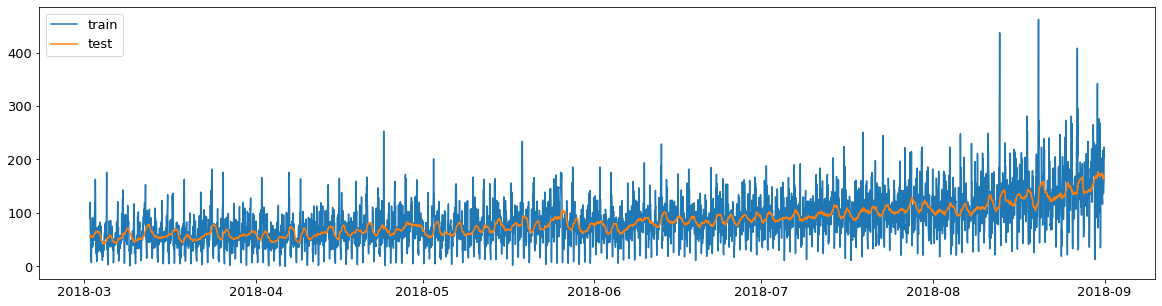

In [27]:
plot(taxi_hour.num_orders, taxi_hour.roll_mean_24)

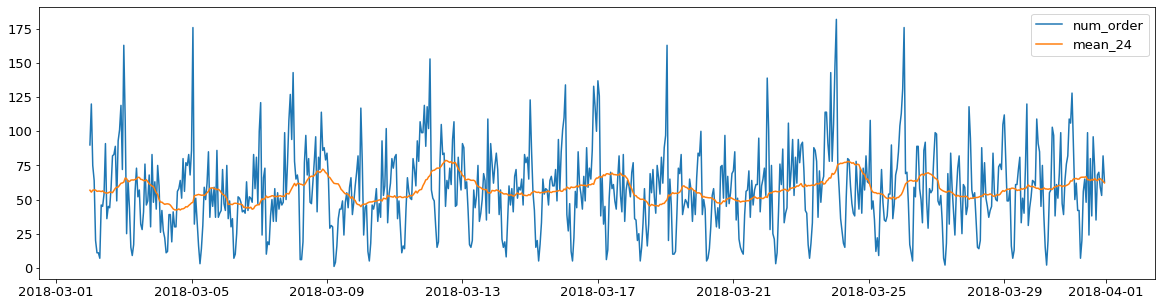

In [28]:
# посмотрим на март (есть праздники)
df = taxi_hour["2018-03-01":"2018-03-31"]
plot(df.num_orders, df.roll_mean_24, legend=['num_order', 'mean_24'])

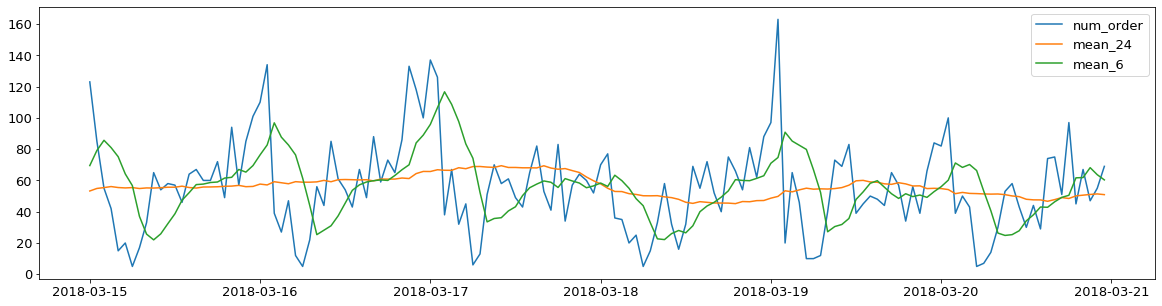

In [29]:
# посмотрим поближе на дни марта
df = taxi_hour["2018-03-15":"2018-03-20"]
plot(df.num_orders, df.roll_mean_24, df.roll_mean_6, legend=['num_order', 'mean_24', 'mean_6'])

Видно, что наблюдается периодичность значений для каждого дня. Значит, имеет значение время дня.

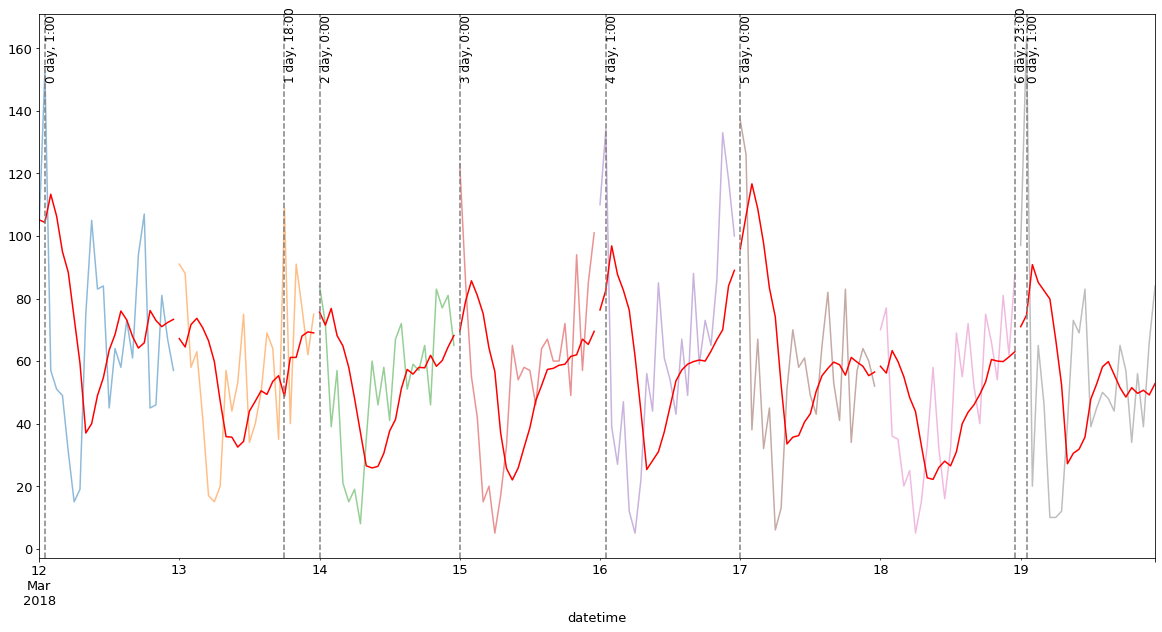

In [30]:
# посмотрим поближе на дни марта
_, ax = plt.subplots(1, figsize=(20,10))

for i in range(12, 20):
  temp = "2018-03-{} ".format(i)
  begin = temp+'00'
  end = temp+'23'
  df = taxi_hour[begin:end]

  df.num_orders.plot(ax=ax, alpha=0.5)
  df.roll_mean_6.plot(ax=ax, color='red')

  max_time = df.num_orders.idxmax()
  # print(max_time)
  ax.axvline(x=max_time, linestyle='--', color='gray')
  ax.annotate('{} day, {}:00'.format(max_time.dayofweek, max_time.hour), xy=(max_time, 150), fontsize=12, rotation=90)

plt.show()

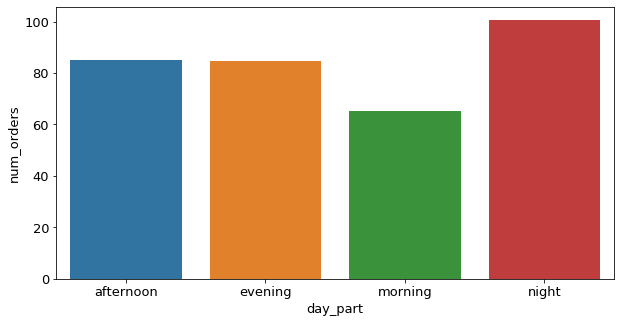

In [31]:
_, ax = plt.subplots(1, figsize=(10,5))
sns.barplot(x="day_part", 
            y="num_orders", 
            ax=ax,
            data=taxi_hour.groupby('day_part')['num_orders'].mean().reset_index());
plt.show()

* Больше всего заказов по ночам
* Меньше всего - по утрам
* Среднее количество заказов днем и вечером

## 3. Обучение

In [32]:
tscv = TimeSeriesSplit(n_splits=2)
X_train, y_train, X_test, y_test = test_split(taxi_hour, 'num_orders', test_size=0.1)
cat_features=['month','day','dayofweek','hour','weekend','holiday','day_part']

### CatBoost

RMSE train:          17.056218528816274
RMSE test (max=48):  41.049037610847606


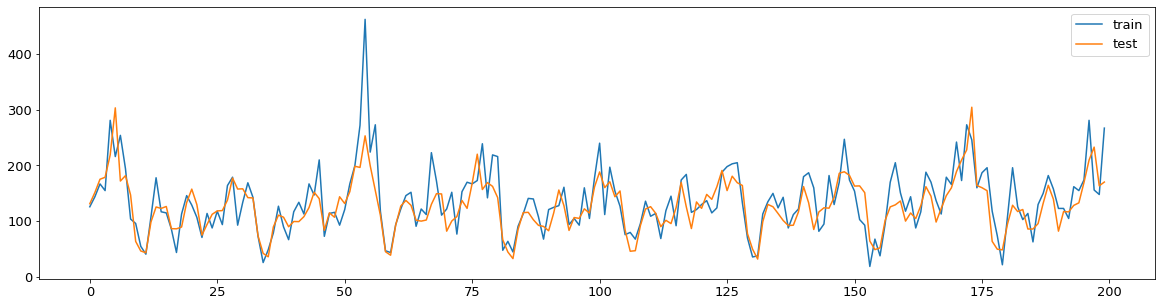

In [33]:
# params = {
#     "iterations": [500, 1000],
#     "depth": [3, 5],
#     "l2_leaf_reg": [3., .05, .005]
# }
# m = CatBoostRegressor(cat_features=cat_features, verbose=False)
# gsearch = GridSearchCV(m, cv=tscv, param_grid=params, scoring=make_scorer(rmse))
# gsearch.fit(X_train, y_train)
# print(gsearch.best_params_)
# print(gsearch.best_score_)
# cbr = gsearch.best_estimator_

cbr = CatBoostRegressor(cat_features=cat_features, verbose=False,
                        depth=5, iterations=1000, l2_leaf_reg=0.005)

cbr = fit_model(cbr, X_train, y_train, X_test, y_test)

### LinearRegression

In [34]:
# подготовка данных для обучения - кодирование категориальных признаков
taxi_hour_enc = taxi_hour.copy()

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit_transform(taxi_hour_enc[['day_part']]).toarray()

enc_df = pd.DataFrame(enc.fit_transform(taxi_hour_enc[['day_part']]).toarray()).astype('int')
enc_df = enc_df.set_axis(enc.categories_, axis=1)
enc_df.index = taxi_hour_enc.index
taxi_hour_enc = taxi_hour_enc.join(enc_df.set_axis(enc.categories_, axis=1)).drop('day_part', axis=1)
taxi_hour_enc.head()

,num_orders,month,day,dayofweek,hour,weekend,holiday,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,roll_mean_24,roll_mean_6,"(afternoon,)","(evening,)","(morning,)","(night,)"
datetime,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,3,2,4,0,0,0,58.0,113.0,66.0,61.0,45.0,73.0,56.833333,69.333333,0,0,0,1
2018-03-02 01:00:00,120,3,2,4,1,0,0,90.0,58.0,113.0,66.0,61.0,45.0,55.416667,72.166667,0,0,0,1
2018-03-02 02:00:00,75,3,2,4,2,0,0,120.0,90.0,58.0,113.0,66.0,61.0,56.875000,84.666667,0,0,0,1
2018-03-02 03:00:00,64,3,2,4,3,0,0,75.0,120.0,90.0,58.0,113.0,66.0,57.041667,87.000000,0,0,0,1
2018-03-02 04:00:00,20,3,2,4,4,0,0,64.0,75.0,120.0,90.0,58.0,113.0,56.958333,86.666667,0,0,0,1


In [35]:
X_train_enc, y_train, X_test_enc, y_test = test_split(taxi_hour_enc, 'num_orders', test_size=0.1)

RMSE train:          29.396404278493634
RMSE test (max=48):  49.68814131932492


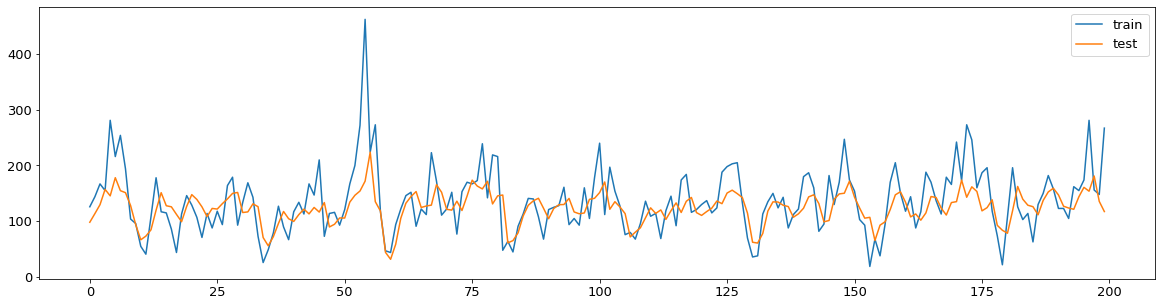

In [36]:
# params = {
#     "fit_intercept": [True, False],
#     "normalize": [False, True],
#     "copy_X": [True, False]
# }
# gsearch = GridSearchCV(LinearRegression(), cv=tscv, param_grid=params, scoring=make_scorer(rmse))
# gsearch.fit(X_train_enc, y_train)
# print(gsearch.best_params_)
# print(gsearch.best_score_)
# lnr = gsearch.best_estimator_

lnr = fit_model(LinearRegression(), X_train_enc, y_train, X_test_enc, y_test)

### Ridge

RMSE train:          29.39641083824749
RMSE test (max=48):  49.69026017171034


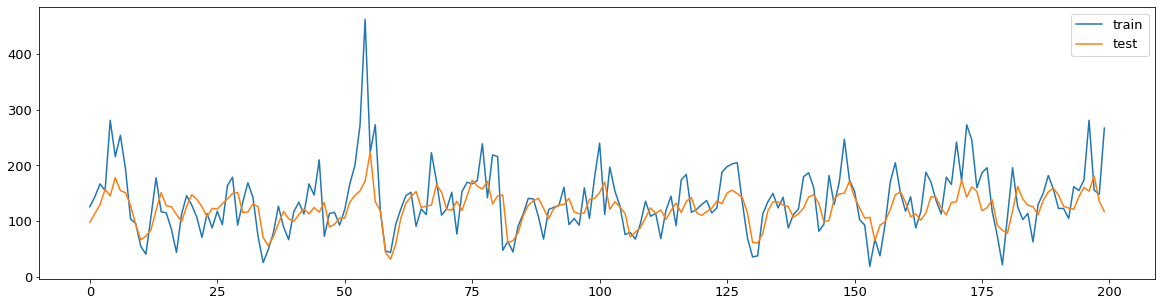

In [37]:
# params = {
#     "alpha": [1., 0.1, 0.01],
#     "solver": ['auto','svd','cholesky','lsqr','sparse_cg','sag','saga'],
#     "max_iter": [100, 1000, 2000],
#     "tol": [0.001, 0.01, 0.0001]
# }
# gsearch = GridSearchCV(Ridge(), cv=tscv, param_grid=params, scoring=make_scorer(rmse))
# gsearch.fit(X_train_enc, y_train)
# print(gsearch.best_params_)
# print(gsearch.best_score_)
# rdg = gsearch.best_estimator_

rdg = fit_model(Ridge(alpha=.0001, max_iter=1000, solver='sparse_cg', tol=0.00001), 
                X_train_enc, y_train, X_test_enc, y_test)

### RandomForestRegressor

RMSE train:          27.164193495252707
RMSE test (max=48):  61.73857195084821


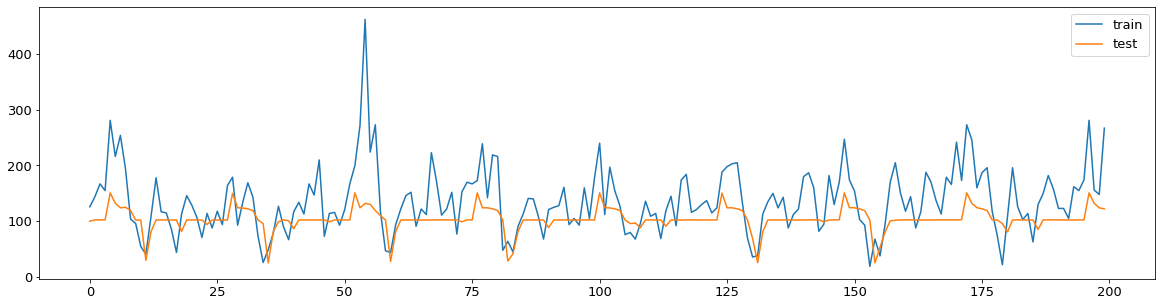

In [38]:
# params = {
#     "max_depth": [3, 5],
#     "n_estimators": [1000],
#     "min_samples_leaf": [1, 2],
# }
# gsearch = GridSearchCV(RandomForestRegressor(), cv=tscv, param_grid=params, scoring=make_scorer(rmse))
# gsearch.fit(X_train_enc, y_train)
# print(gsearch.best_params_)
# print(gsearch.best_score_)
# rf = gsearch.best_estimator_

rf = fit_model(RandomForestRegressor(max_depth=3, min_samples_leaf=2, n_estimators=1000), 
                X_train_enc, y_train, X_test_enc, y_test)

## 4. Тестирование

In [39]:
fit_predict_data = OrderedDict()

In [40]:
test_result = list(test_model(cbr, X_train, y_train, X_test, y_test))
fit_predict_data = pd.DataFrame({'CatBoost': test_result}).set_axis(['train', 'test'])

Train RMSE: 17.056218528816274
Test  RMSE: 41.049037610847606


In [41]:
fit_predict_data['LinearRegression'] = list(test_model(lnr, X_train_enc, y_train, X_test_enc, y_test))

Train RMSE: 29.396404278493634
Test  RMSE: 49.68814131932492


In [42]:
fit_predict_data['Ridge'] = list(test_model(rdg, X_train_enc, y_train, X_test_enc, y_test))

Train RMSE: 29.39641083824749
Test  RMSE: 49.69026017171034


In [43]:
fit_predict_data['RandomForest'] = list(test_model(rf, X_train_enc, y_train, X_test_enc, y_test))

Train RMSE: 27.164193495252707
Test  RMSE: 61.73857195084821


In [44]:
fit_predict_data

,CatBoost,LinearRegression,Ridge,RandomForest
train,17.056219,29.396404,29.396411,27.164193
test,41.049038,49.688141,49.690260,61.738572


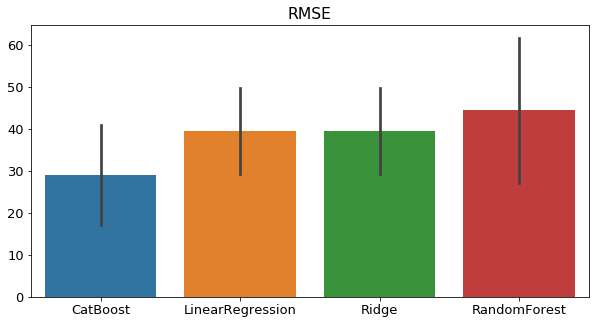

In [45]:
fig, ax = plt.subplots(1, figsize=(10, 5))
sns.barplot(data=fit_predict_data, ax=ax)
ax.set_title('RMSE')
plt.show()

## Вывод

В результате исследования выявлено, что наиболее подходящей моделью является CatBoost, который достиг минимального значения метрики RMSE - ~40.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48